In [ ]:
filename1 = 'HW/abai_poems_eng.txt'
filename2 = 'HW/civil_code_eng.txt'

with open(filename1, 'rt') as file:
    corpus_a = file.read()

with open(filename2, 'rt') as file:
    corpus_b = file.read()

In [107]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from typing import List
import re
import string
from nltk.tokenize import word_tokenize

# Removes punctuation
def clean_punctuation(tokens: List[str]) -> List[str]:
    return [w.strip(string.punctuation) for w in tokens if w.strip(string.punctuation)]

# Tokenize function
def tokenize(text: str) -> List[str]:
    return re.split(r"\s+", text)

custom_stopwords = set([
    "'", "♪", "-", ">", "=", ".", ",", "á", "é", 
    "0", "1", "2", "3", "4", "5", "6", "7", "8", "9", 
    "a", "b", "c", "d", "e", "f", "g", "h", "i", "j", 
    "k", "l", "m", "n", "o", "p", "q", "r", "s", "t", 
    "u", "v", "w", "x", "y", "z",
    '"', "”", "“", "¿", "í", "ó", "&", ">", "<", "(", ")", "[", "]", "{", "}", ":", ";", "!", "?", "/", "\\", 
    "1", "2", "3", "4", "5", "6", "7", "8", "9", "0", 
    ])

# Modified function to filter both standard stopwords and custom stopwords
def filter_stopwords(tokens: List[str]) -> List[str]:
    stop_words = set(stopwords.words('english'))  # Load standard stopwords
    all_stopwords = stop_words.union(custom_stopwords)  # Merge with custom list
    
    # Ensure lowercase matching and remove empty or whitespace-only tokens
    return [w.strip() for w in tokens if w.lower().strip() not in all_stopwords and w.strip()]

# Remove any remaining numbers (including inline like 'land4' and years like '1901')
corpus_a_clean = re.sub(r'\d+', '', corpus_a)

# Preprocess both corpora
corpus_a_tokens = filter_stopwords(clean_punctuation(tokenize(corpus_a_clean)))
corpus_b_tokens = filter_stopwords(clean_punctuation(tokenize(corpus_b)))

In [108]:
def assign_labels(tokens):
    labels = []
    label = 0
    
    for i, token in enumerate(tokens):
        # Check if the token is in all caps
        if token.isupper() and len(token)>3:
            # If it's the first all caps token or it's consecutive, keep the same label
            if i == 0 or (tokens[i-1].isupper() and len(token)>3):
                labels.append(label)
            else:
                label += 1
                labels.append(label)
        else:
            # If it's not all caps, just add a new label
            labels.append(label)
    
    return labels

def assign_labels_b(tokens):
    labels = []
    label = 0
    
    for i, token in enumerate(tokens):
        if i == 0 or (token.isdigit() and tokens[i-1].lower() == 'article'):
            label += 1
            labels.append(label)
        else:
            labels.append(label)
    
    return labels

corpus_a_labels = assign_labels(corpus_a_tokens)
corpus_a_tokens = [token.lower() for token in corpus_a_tokens]

corpus_b_labels = assign_labels_b(corpus_b_tokens)
corpus_b_tokens = [token.lower() for token in corpus_b_tokens]

In [111]:
df = pd.DataFrame({'Token': corpus_a_tokens, 'Label': corpus_a_labels})
result = df.groupby('Label')['Token'].apply(lambda x: ' '.join(x)).reset_index()

# Convert to list of strings
result_list = result['Token'].tolist()
result_list[0:10]

["abay's poems",
 'respect seen many muslims infidels youth never seen poor man know prayer like abraly tried teach recitation confused know make intention namaz makes lot noise namaz like someone gives piece land donkey namaz complete prayer everything goes wind ennatayina kalkausar sinner immediately thought feet said sing laugh reward recitation think brain ear qiraat arabic reading reading quran nafil arabic prayer recited addition obligatory five daily prayers namazsham persian prayer recited end day sham evening night jer utsuk lay sick person ground sunset facing west stand ennatayina kalkausar truly honor reward like water kausar man body shit brought body shit man body shit carried stink shit die boast equal sign ignorance yesterday child come many years become clear cannot remain one position love person feel wisdom god interesting life besides',
 "moments person sometimes person's mind filled worry art given god revealed blue cloud quiet agreement like water stone spring dir

In [125]:
from nrclex import NRCLex

def extract_emotions(text):
    emotion_analysis = NRCLex(text)
    return emotion_analysis.affect_frequencies

# Extract emotions for both corpora
emotion_data = []
for text, label in zip(corpus_a_tokens, corpus_a_labels):
    emotion_counts = extract_emotions(text)
    emotion_counts["corpus"] = "A"
    emotion_counts["label"] = label
    emotion_data.append(emotion_counts)
for text, label in zip(corpus_b_tokens, corpus_b_labels):
    emotion_counts = extract_emotions(text)
    emotion_counts["corpus"] = "B"
    emotion_counts["label"] = label
    emotion_data.append(emotion_counts)

df_emotions = pd.DataFrame(emotion_data).fillna(0)

In [114]:
df_emotions_sum = df_emotions.groupby(['corpus','label']).sum().reset_index()

In [118]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.formula.api import ols
import statsmodels.api as sm

ANOVA results for fear:
                 sum_sq     df         F        PR(>F)
C(corpus)   159.992408    1.0  71.70882  1.156690e-16
Residual   1816.147872  814.0       NaN           NaN
Tukey HSD results for fear:
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
  group1   group2 meandiff p-adj lower upper  reject
----------------------------------------------------
civil code  poems   1.3682   0.0 1.051 1.6853   True
----------------------------------------------------
ANOVA results for anger:
                 sum_sq     df          F        PR(>F)
C(corpus)   136.368831    1.0  96.934712  1.100170e-21
Residual   1145.144254  814.0        NaN           NaN
Tukey HSD results for anger:
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
  group1   group2 meandiff p-adj lower  upper reject
----------------------------------------------------
civil code  poems   1.2631   0.0 1.0113 1.515   True
----------------------------------------------------
ANOVA results for trust:
        

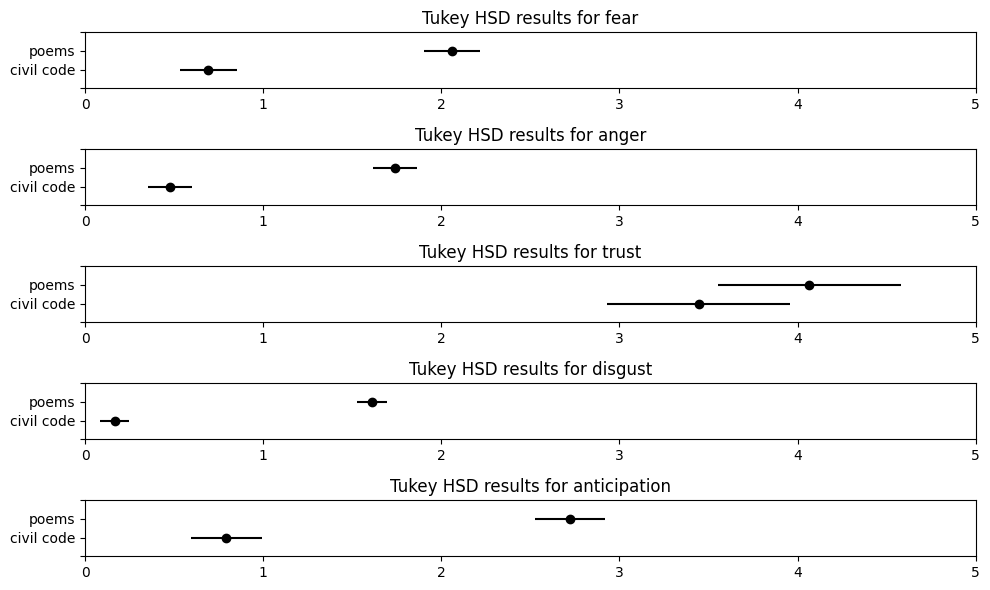

In [132]:
df_emotions_sum['corpus'] = df_emotions_sum['corpus'].replace({'A': 'poems', 'B': 'civil code'})
# List of metrics to analyze
metrics = ['fear', 'anger', 'trust', 'disgust', 'anticipation']

# Create a figure for all Tukey HSD plots
fig, axes = plt.subplots(nrows=len(metrics), ncols=1, figsize=(30, 15 * len(metrics)))

# Perform ANOVA and Tukey HSD test for each metric
for i, metric in enumerate(metrics):
    # Perform ANOVA
    model = ols(f'{metric} ~ C(corpus)', data=df_emotions_sum).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    print(f'ANOVA results for {metric}:\n', anova_table)
    
    # Perform Tukey HSD test
    tukey = pairwise_tukeyhsd(endog=df_emotions_sum[metric], groups=df_emotions_sum['corpus'], alpha=0.05)
    print(f'Tukey HSD results for {metric}:\n', tukey)
    
    # Plot Tukey HSD results
    tukey.plot_simultaneous(ax=axes[i])
    axes[i].set_title(f'Tukey HSD results for {metric}')
    axes[i].set_xlim(0, 5)

# Adjust layout
plt.tight_layout()
plt.show()